# Partie I. Comprendre les données

In [72]:
# 1. Read excel
import pandas as pd
df = pd.read_excel('Donnees/Donnees_v3.xlsx', engine='openpyxl')
df=df.drop(columns=['Commentaires'])

In [73]:
n_types_including_nan = df['Type'].nunique(dropna=False)
print(n_types_including_nan)

28


In [74]:
# 2. Prepare the original Series and remove/standardize spaces
orig = df['Type']

# 3. Construct the mapping dictionary (note: all keys are lowercase with no leading/trailing spaces)
mapping = {
    'cut-off':                          'Cut off',
    'cut off':                          'Cut off',
    'ecart non récurrent, cut-off importants': 'Cut off',

    'analyse':                          'Analyse',
    'analyse en cours':                 'Analyse',
    'analyse en cours car écart non récurrent': 'Analyse',
    "analyse en cours sur des flux manquants à l'actif": 'Analyse',

    'gate':                             'GATE',
    'gate total':                       'GATE',
    'gate partiel':                     'GATE',

    'récurrent':                        'Recurrence',
    'récurrence':                       'Recurrence',

    'analyse en cours sur ost fusion traité en arbitrage': 'OST',
    'ost':                              'OST',

    'process':                          'Process',

    'campagne':                         'Campagne'
}

# 4. Normalization
#    mask_notna is used to distinguish real NaN values
mask_notna = orig.notna()
#    strip + lower
lowered = orig[mask_notna].str.strip().str.lower()
mapped = lowered.map(mapping)
df.loc[mask_notna, 'Type'] = mapped.fillna(orig[mask_notna].str.strip())

# 5. 输出到新的 Excel
df.to_excel('Donnees/Donnees_v4.xlsx', index=False)
print("Donnees_v4.xlsx，Type")

# 6. 检查各类别行数
print(df['Type'].value_counts(dropna=False))

已生成 Donnees_v4.xlsx，Type 列已完成规范化。
Type
Process                                1214
Cut off                                 909
OST                                     369
Analyse                                 319
Incident                                317
NaN                                     260
Campagne                                149
GATE                                     99
Recurrence                               37
Autres                                    2
Probleme macros (nominal incorrect)       2
Name: count, dtype: int64


In [75]:
print(df.shape)

(3677, 12)


In [76]:
to_remove = [
    'Process',
    'Analyse',
    'Incident dû au passage de 2 ordres "REG-ORDRES" en plus de l\'ordre initial.',
    'Autres',
    'Achat ANC de 2,12 M€',
    'Probleme macros (nominal incorrect)',
    'Suspendu suite crise UKRAINE/RUSSIE AM AF'
]

df_filtered = df[df['Type'].notna() & ~df['Type'].isin(to_remove)].copy()

df_filtered.to_excel('Donnees/Donnees_v5.xlsx', index=False)

print(df_filtered['Type'].value_counts(dropna=False))

Type
Cut off       909
OST           369
Incident      317
Campagne      149
GATE           99
Recurrence     37
Name: count, dtype: int64


In [77]:
print(df_filtered.shape)

(1880, 12)


In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Read the cleaned and filtered data
df = pd.read_excel('Donnees/Donnees_v5.xlsx', engine='openpyxl')


Nombre d’échantillons et proportion par Type
            count  proportion
Type                         
Cut off       909    0.483511
OST           369    0.196277
Incident      317    0.168617
Campagne      149    0.079255
GATE           99    0.052660
Recurrence     37    0.019681
Comparaison du volume d’échantillons selon chaque Type
Nombre d’échantillons


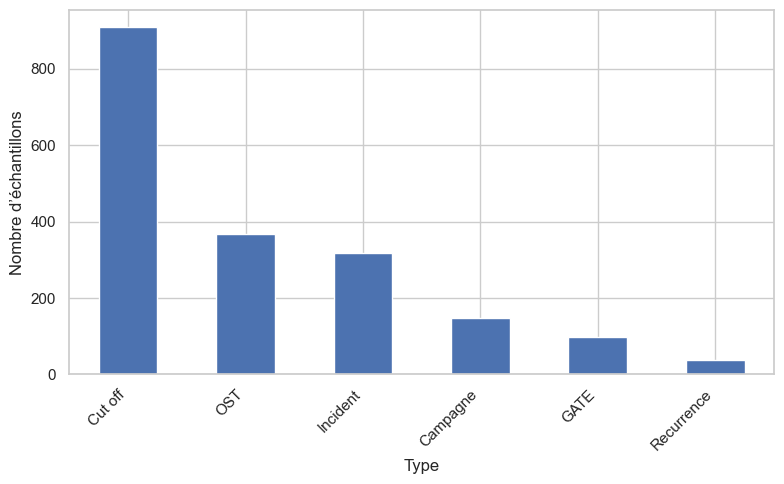

Comparaison du volume d’échantillons selon chaque Source
         count  proportion
Source                    
GBProd    1364    0.725532
Epargne    221    0.117553
GB2000     150    0.079787
Glux       145    0.077128


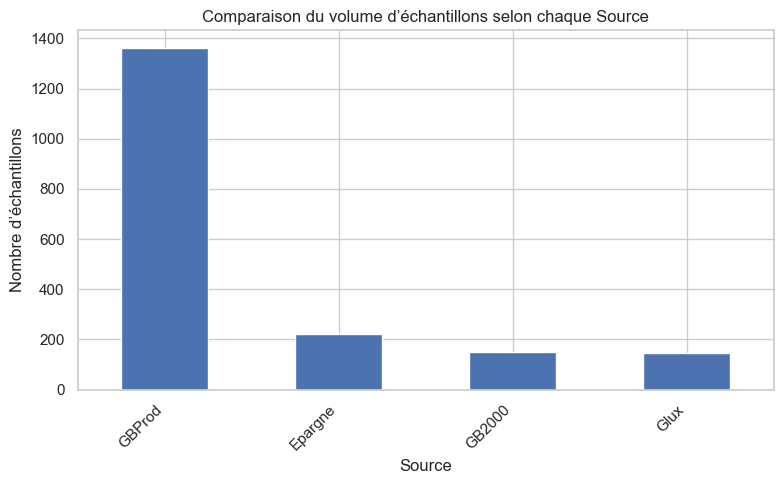

In [79]:
# 2. Calculate the count and proportion of the Type column

type_counts = df['Type'].value_counts(dropna=False)
type_props  = df['Type'].value_counts(normalize=True, dropna=False)

type_summary = pd.DataFrame({
    'count':      type_counts,
    'proportion': type_props
})
print("Nombre d’échantillons et proportion par Type")
print(type_summary)

# 3. Bar chart of Type sample sizes
plt.figure(figsize=(8, 5))
type_counts.plot(kind='bar')
print("Comparaison du volume d’échantillons selon chaque Type")
plt.xlabel('Type')
plt.ylabel('Nombre d’échantillons')
print("Nombre d’échantillons")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Calculate the count and proportion of the Source column
source_counts = df['Source'].value_counts(dropna=False)
source_props  = df['Source'].value_counts(normalize=True, dropna=False)

source_summary = pd.DataFrame({
    'count':      source_counts,
    'proportion': source_props
})

print("Comparaison du volume d’échantillons selon chaque Source")
print(source_summary)

plt.figure(figsize=(8, 5))
source_counts.plot(kind='bar')
plt.title('Comparaison du volume d’échantillons selon chaque Source')
plt.xlabel('Source')
# plt.ylabel('样本数')
plt.ylabel('Nombre d’échantillons')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [80]:
print(df_filtered.dtypes)

Source               object
Année                 int64
Mois                float64
Code ISIN            object
Libellé              object
VL                  float64
Quantité Actif      float64
Quantité passif     float64
Ecart quantité      float64
Ecart valorisé      float64
Ecart valorisé.1    float64
Type                 object
dtype: object


In [81]:
s = df_filtered['Ecart valorisé.1'].astype(str)

# 1. Identify which values "don’t really look like numbers":
mask_bad = ~s.str.match(r'^-?\d+(\.\d+)?$')
bad_vals = s[mask_bad].unique()
print("les valeurs ci-dessus ne peuvent pas en float：")
print(bad_vals)

# 2. Cleaning: remove all spaces (including non-breaking spaces) and treat commas as decimal points
s_clean = (
    s
    .str.replace(r'[\u00A0\s]', '', regex=True)
    .str.replace(',', '.', regex=False)
)

# 3. Convert to numeric values

df_filtered['Ecart valorisé.1'] = pd.to_numeric(s_clean, errors='coerce')

# 4. Check the dtype again
print(df_filtered['Ecart valorisé.1'].dtype)    # 应该是 float64

# 5. Check if there are new NaN values (indicating rows where conversion failed)
n_failed = df_filtered['Ecart valorisé.1'].isna().sum()
print(f"failed {n_failed} lines")


les valeurs ci-dessus ne peuvent pas en float：
['nan']
float64
failed 283 lines


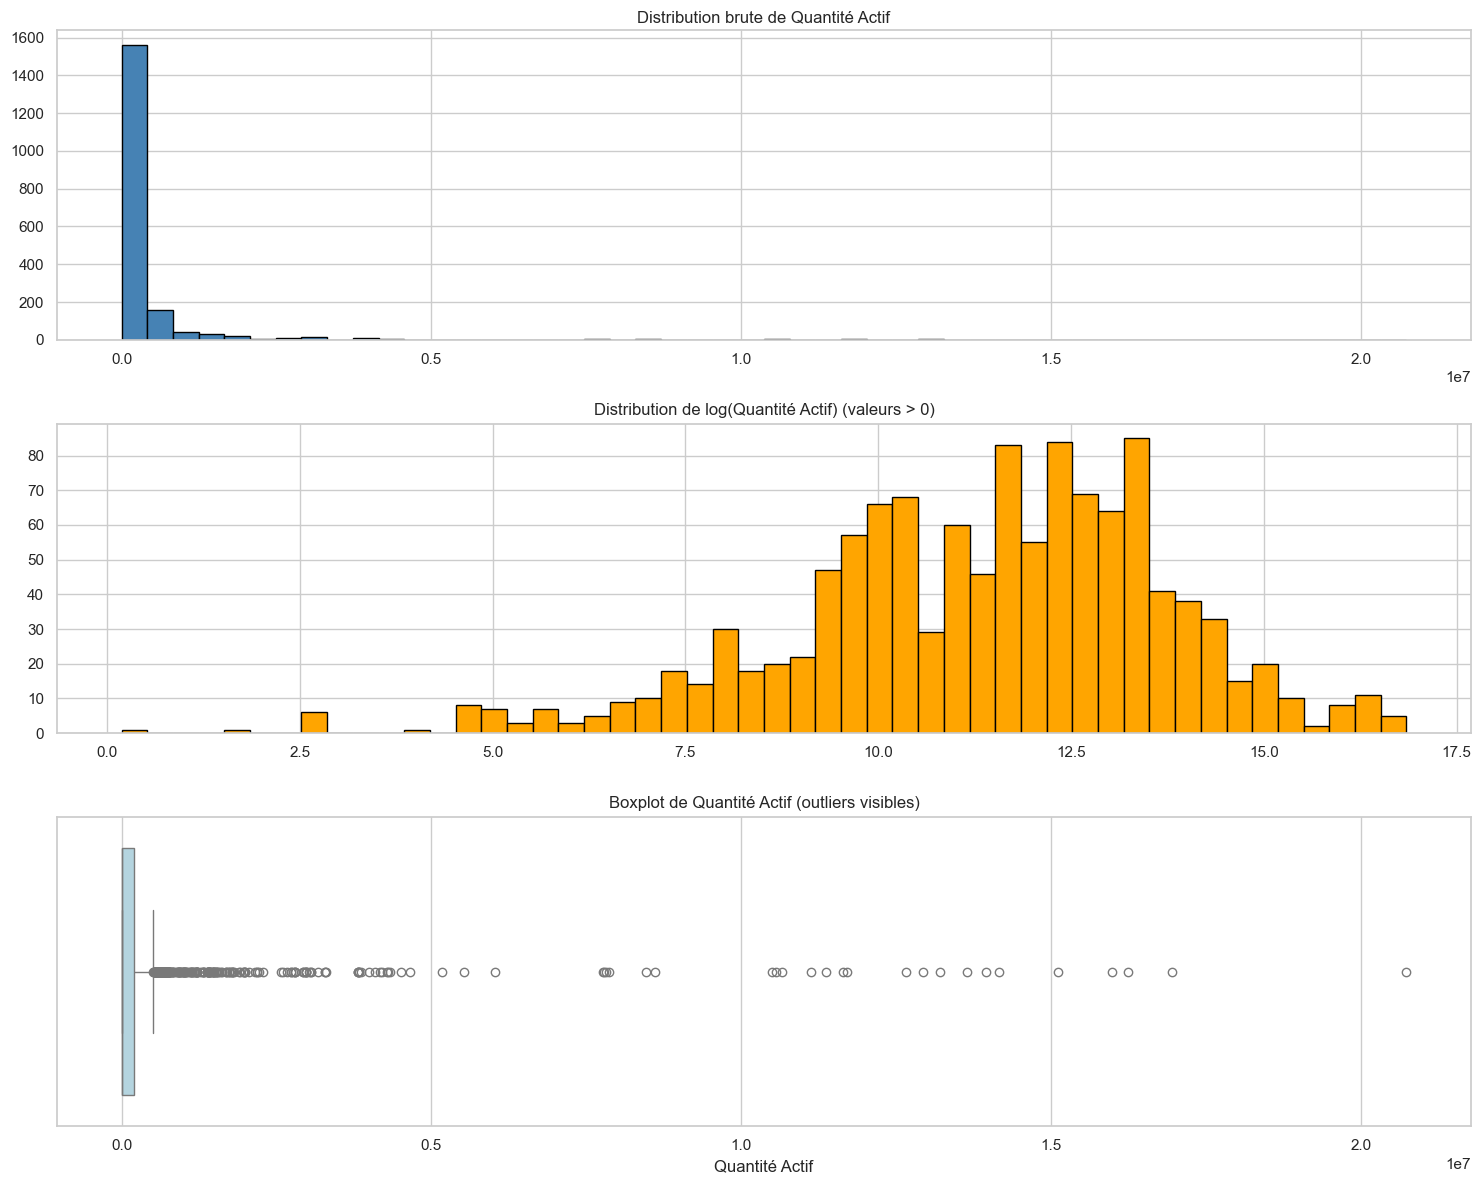

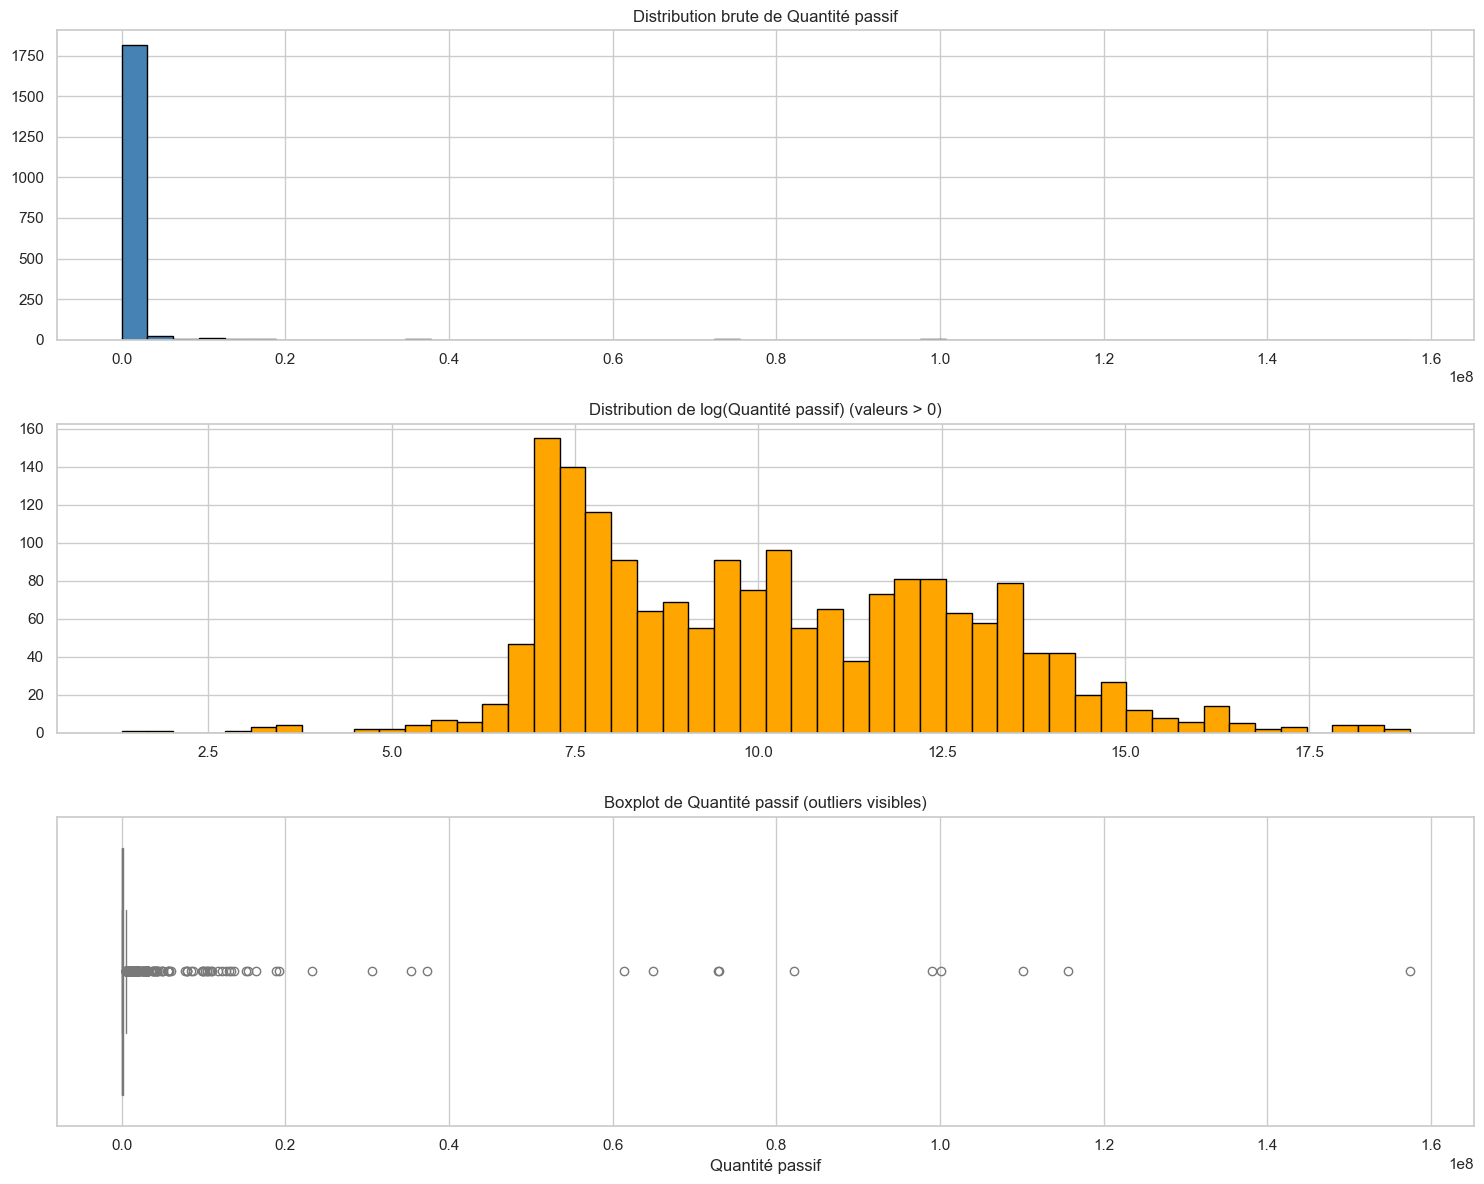

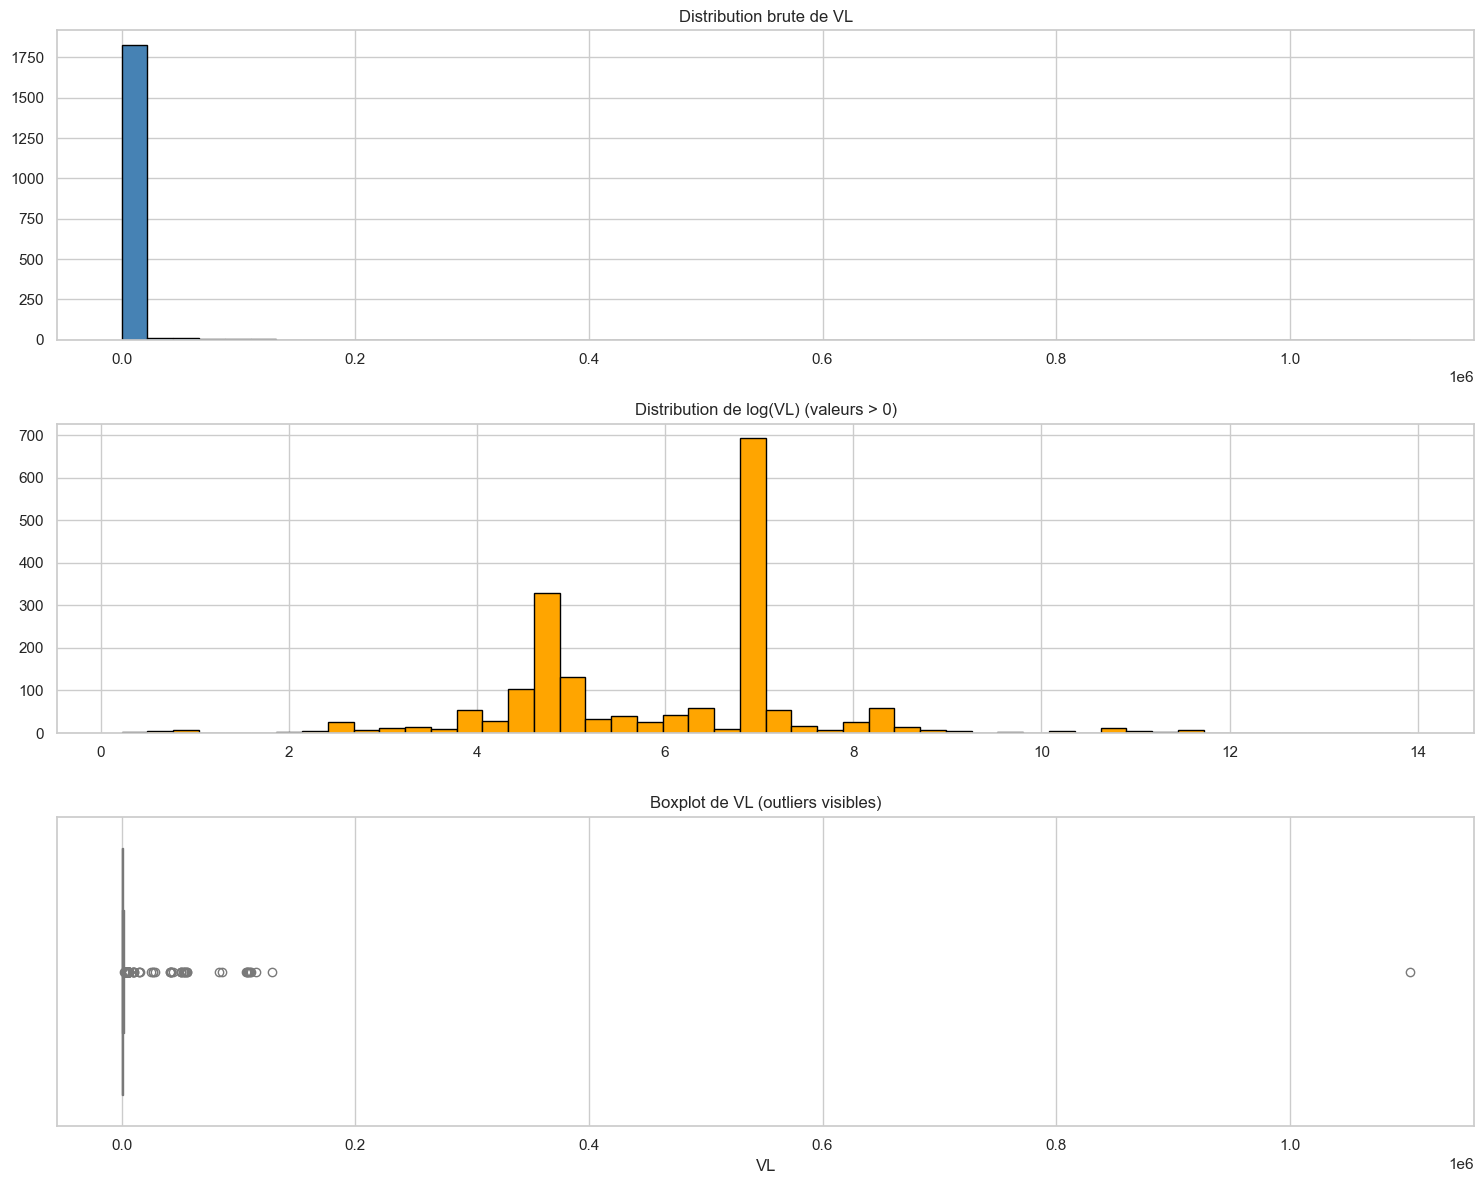

In [83]:
import seaborn as sns

sns.set(style="whitegrid")

def plot_distribution_with_outliers(df, column, figsize=(15, 12)):
    fig, axes = plt.subplots(3, 1, figsize=figsize)

        # 1. Original histogram
    axes[0].hist(df[column], bins=50, color='steelblue', edgecolor='black')
    axes[0].set_title(f"Distribution brute de {column}")

    # 2. Log-transformed histogram (apply log only to positive values)
    positive_values = df[df[column] > 0][column]
    if len(positive_values) > 0:
        axes[1].hist(np.log1p(positive_values), bins=50, color='orange', edgecolor='black')
        axes[1].set_title(f"Distribution de log({column}) (valeurs > 0)")
    else:
        axes[1].set_title(f"Pas de valeurs positives pour {column}")
    # 3. Boxplot (showing outliers)
    sns.boxplot(x=df[column], ax=axes[2], color="lightblue")
    axes[2].set_title(f"Boxplot de {column} (outliers visibles)")

    plt.tight_layout()
    plt.show()

plot_distribution_with_outliers(df, "Quantité Actif")
plot_distribution_with_outliers(df, "Quantité passif")
plot_distribution_with_outliers(df,"VL")

== DataFrame Info ==
<class 'pandas.core.frame.DataFrame'>
Index: 1880 entries, 0 to 3676
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Source            1880 non-null   object 
 1   Année             1880 non-null   int64  
 2   Mois              1880 non-null   float64
 3   Code ISIN         1880 non-null   object 
 4   Libellé           1880 non-null   object 
 5   VL                1858 non-null   float64
 6   Quantité Actif    1880 non-null   float64
 7   Quantité passif   1880 non-null   float64
 8   Ecart quantité    1880 non-null   float64
 9   Ecart valorisé    1880 non-null   float64
 10  Ecart valorisé.1  1597 non-null   float64
 11  Type              1880 non-null   object 
dtypes: float64(7), int64(1), object(4)
memory usage: 642.4 KB

== 5 premières lignes ==
   Source  Année  Mois     Code ISIN                         Libellé       VL  \
0  GBProd   2022   3.0  FR0013473667     GF Infra

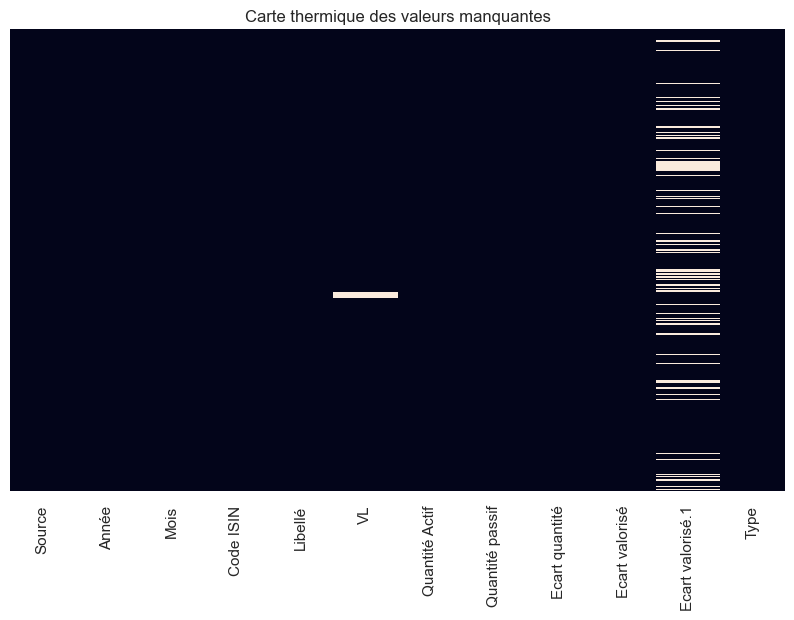

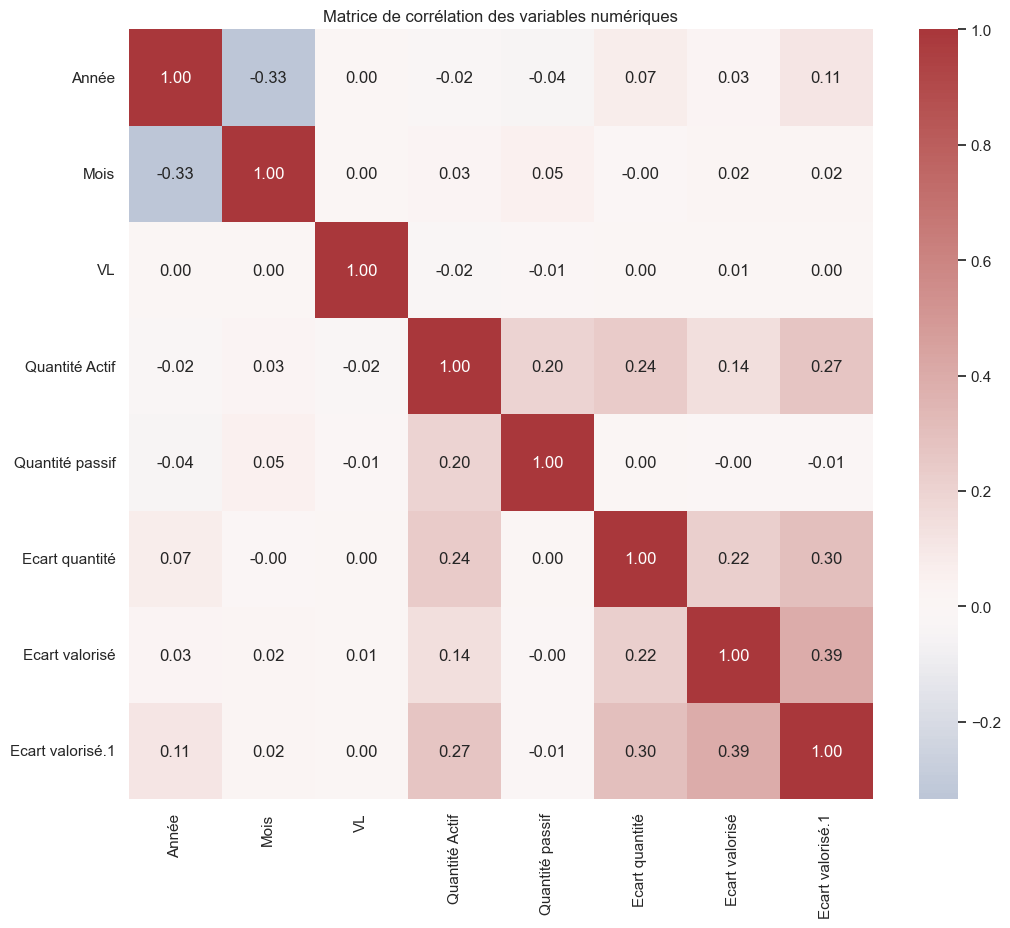


== VIF (Facteur d'inflation de la variance) ==
            feature       VIF
0             Année  4.492830
1              Mois  4.432288
2                VL  1.009475
3    Quantité Actif  1.261889
4   Quantité passif  1.066685
5    Ecart quantité  1.159885
6    Ecart valorisé  1.200160
7  Ecart valorisé.1  1.301019


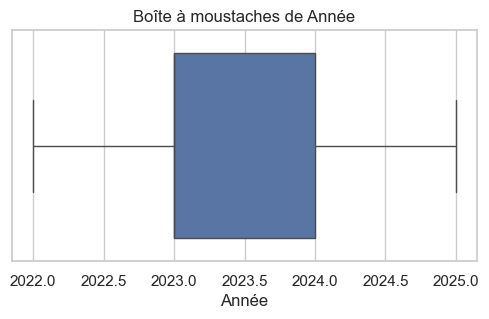

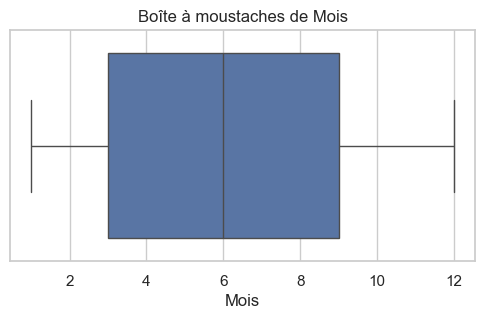

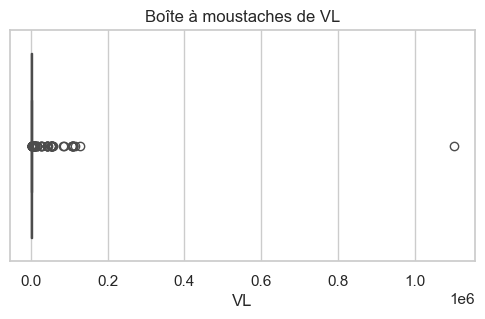

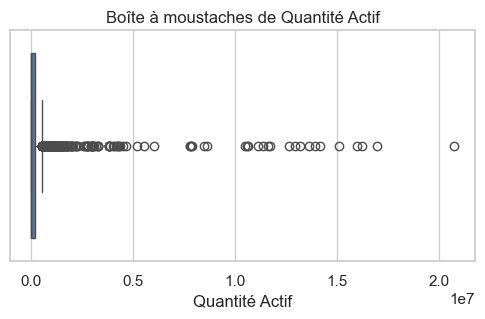

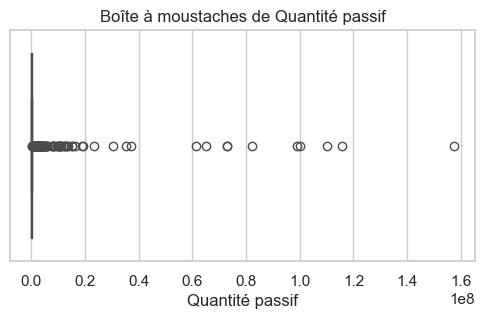

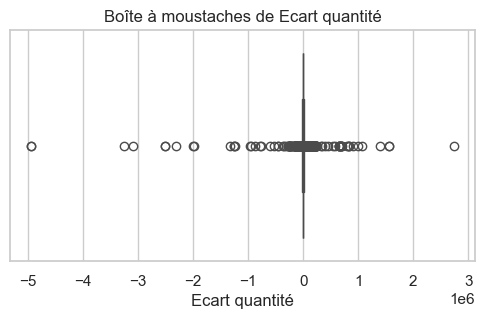

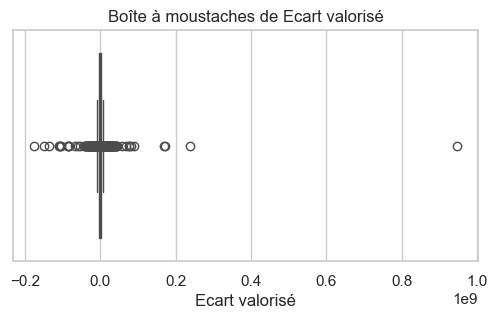

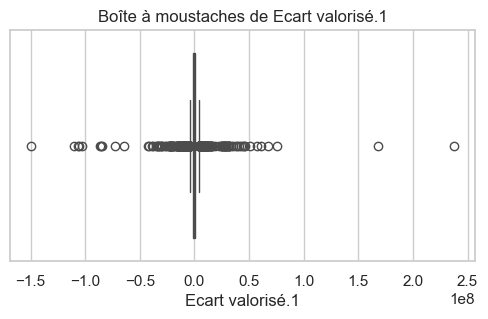

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

print("== DataFrame Info ==")
df_filtered.info(memory_usage="deep")

print("\n== 5 premières lignes ==")
print(df_filtered.head())


print("\n== Valeurs manquantes par colonne ==")
print(df_filtered.isna().sum().to_frame(name="missing_count"))
print("\n== Nombre de valeurs uniques par colonne ==")
print(df_filtered.nunique().to_frame(name="n_unique"))

print("\n== Statistiques descriptives des variables numériques ==")
print(df_filtered.select_dtypes(include=[np.number]).describe().T)

cat_cols = df_filtered.select_dtypes(include=["object", "category"]).columns
for col in cat_cols:
    print(f"\n-- Comptage des valeurs de {col} --")
    print(df_filtered[col].value_counts(dropna=False))

plt.figure(figsize=(10, 6))
sns.heatmap(df_filtered.isna(), cbar=False, yticklabels=False)
# plt.title("Missing Values Heatmap")
plt.title("Carte thermique des valeurs manquantes")
plt.show()

num_cols = df_filtered.select_dtypes(include=[np.number]).columns
corr = df_filtered[num_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
# plt.title("Numeric Features Correlation Matrix")
plt.title("Matrice de corrélation des variables numériques")
plt.show()


X = df_filtered[num_cols].dropna()
vif_data = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

print("\n== VIF (Facteur d'inflation de la variance) ==")
print(vif_data)

for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_filtered[col])
    plt.title(f"Boxplot of {col}")
    plt.title(f"Boîte à moustaches de {col}")
    plt.show()


# Partie II : Préparation des donnés

## Étape 1 : Filtrage des classes - déjà done

## Étape 2 : uniformisation des formats des colonnes numériques

In [85]:
import pandas as pd
cols_to_clean = ['VL', 'Ecart valorisé', 'Ecart valorisé.1']

def clean_numeric_column(s: pd.Series) -> pd.Series:

    s_str = s.astype(str)
    s_nospace = s_str.str.replace(r'[\u00A0\s]+', '', regex=True)
    s_dot = s_nospace.str.replace(',', '.', regex=False)
    return pd.to_numeric(s_dot, errors='coerce')

for col in cols_to_clean:
    df_filtered[col] = clean_numeric_column(df_filtered[col])

print(df_filtered[cols_to_clean].dtypes)
print(df_filtered[cols_to_clean].isna().sum())

VL                  float64
Ecart valorisé      float64
Ecart valorisé.1    float64
dtype: object
VL                   22
Ecart valorisé        0
Ecart valorisé.1    283
dtype: int64


## Étape 3 : Traitement des valeurs manquantes

In [86]:
df_filtered = df_filtered.sort_values(['Code ISIN', 'Année', 'Mois'])

df_filtered['VL_prev'] = df_filtered.groupby('Code ISIN')['VL'].shift(1)
df_filtered['Ecart valorisé.1'] = df_filtered['Ecart quantité'] * df_filtered['VL_prev']

df_filtered['VL'] = (
    df_filtered['VL']
    .fillna(df_filtered.groupby('Code ISIN')['VL'].transform('median'))
    .fillna(df_filtered['VL'].median())
)

df_filtered['Ecart valorisé.1'] = (
    df_filtered['Ecart valorisé.1']
    .fillna(df_filtered.groupby('Code ISIN')['Ecart valorisé.1'].transform('median'))
    .fillna(0)
)

print(df_filtered[['VL', 'Ecart valorisé.1']].isna().sum())

VL                  0
Ecart valorisé.1    0
dtype: int64


## Étape 4 : Traitement des valeurs extrêmes (troncature de Winsor[19]+ suppression des valeurs aberrantes)

In [87]:
print("原始数据量:", len(df_filtered))
df_filtered =df_filtered[df_filtered['VL'] < 5e5]
print("删除后数据量:", len(df_filtered))


原始数据量: 1880
删除后数据量: 1879


In [88]:

cols_to_winsorize = [ 'Quantité Actif',
    'Quantité passif',
    'Ecart quantité',
    'Ecart valorisé',
    'Ecart valorisé.1']

lower_pct, upper_pct = 0.01, 0.99

for col in cols_to_winsorize:
    lower = df_filtered[col].quantile(lower_pct)
    upper = df_filtered[col].quantile(upper_pct)
    df_filtered[f"{col}_win"] = df_filtered[col].clip(lower, upper)

for col in cols_to_winsorize:
    orig = df_filtered[col].quantile([0.01, 0.5, 0.99])
    wins = df_filtered[f"{col}_win"].quantile([0.01, 0.5, 0.99])
    print(f"\n{col} 原始 1/50/99 分位：\n{orig}")
    print(f"{col}_win 截尾后 1/50/99 分位：\n{wins}")


df_filtered = df_filtered.drop(columns=['VL_prev'])



Quantité Actif 原始 1/50/99 分位：
0.01    0.000000e+00
0.50    1.422429e+04
0.99    8.500357e+06
Name: Quantité Actif, dtype: float64
Quantité Actif_win 截尾后 1/50/99 分位：
0.01    0.000000e+00
0.50    1.422429e+04
0.99    8.477732e+06
Name: Quantité Actif_win, dtype: float64

Quantité passif 原始 1/50/99 分位：
0.01    0.000000e+00
0.50    1.780995e+04
0.99    1.403482e+07
Name: Quantité passif, dtype: float64
Quantité passif_win 截尾后 1/50/99 分位：
0.01    0.000000e+00
0.50    1.780995e+04
0.99    1.378401e+07
Name: Quantité passif_win, dtype: float64

Ecart quantité 原始 1/50/99 分位：
0.01   -542269.2724
0.50     -1442.0300
0.99    650821.8892
Name: Ecart quantité, dtype: float64
Ecart quantité_win 截尾后 1/50/99 分位：
0.01   -528767.798128
0.50     -1442.030000
0.99    649240.104424
Name: Ecart quantité_win, dtype: float64

Ecart valorisé 原始 1/50/99 分位：
0.01   -3.575607e+07
0.50   -1.349086e+06
0.99    3.302848e+07
Name: Ecart valorisé, dtype: float64
Ecart valorisé_win 截尾后 1/50/99 分位：
0.01   -3.553768e+07

## Étape 5 : Transformation Symlog

In [89]:
cols = [
    'Quantité Actif_win',
    'Quantité passif_win',
    'Ecart quantité_win',
    'Ecart valorisé_win',
    'Ecart valorisé.1_win'
]

for col in cols:
    new_col = f"{col}_symlog"
    df_filtered[new_col] = np.sign(df_filtered[col]) * np.log1p(np.abs(df_filtered[col]))

print(df_filtered[[c + '_symlog' for c in cols]].head())

print(df_filtered[[c + '_symlog' for c in cols]].describe().T)


      Quantité Actif_win_symlog  Quantité passif_win_symlog  \
1114                  10.400869                   10.138216   
811                    0.000000                    7.684494   
950                    0.000000                    7.550362   
996                    0.000000                    7.976049   
1077                   0.000000                    6.529010   

      Ecart quantité_win_symlog  Ecart valorisé_win_symlog  \
1114                   8.935627                  13.186846   
811                   -7.684494                 -14.591788   
950                   -7.550362                 -14.457589   
996                   -7.976049                 -14.883461   
1077                  -6.529010                 -13.435304   

      Ecart valorisé.1_win_symlog  
1114                     0.000000  
811                      0.000000  
950                    -14.883461  
996                    -14.883461  
1077                     0.000000  
                              co

# Étape 6 : Mise à l’échelle des variables symlog：


In [90]:
print(df_filtered.columns)

Index(['Source', 'Année', 'Mois', 'Code ISIN', 'Libellé', 'VL',
       'Quantité Actif', 'Quantité passif', 'Ecart quantité', 'Ecart valorisé',
       'Ecart valorisé.1', 'Type', 'Quantité Actif_win', 'Quantité passif_win',
       'Ecart quantité_win', 'Ecart valorisé_win', 'Ecart valorisé.1_win',
       'Quantité Actif_win_symlog', 'Quantité passif_win_symlog',
       'Ecart quantité_win_symlog', 'Ecart valorisé_win_symlog',
       'Ecart valorisé.1_win_symlog'],
      dtype='object')


In [91]:
from sklearn.preprocessing import StandardScaler, RobustScaler
symlog_cols = [col + '_symlog' for col in cols]

scaler_std = StandardScaler()
df_filtered[[c + '_std' for c in symlog_cols]] = scaler_std.fit_transform(df_filtered[symlog_cols])

scaler_rob = RobustScaler()
df_filtered[[c + '_rob' for c in symlog_cols]] = scaler_rob.fit_transform(df_filtered[symlog_cols])

print("=== StandardScaler 结果 ===")
print(df_filtered[[c + '_std' for c in symlog_cols]].describe().T[['mean','std']])
print("\n=== RobustScaler 结果 ===")
print(df_filtered[[c + '_rob' for c in symlog_cols]].describe().T[['25%','50%','75%']])


=== StandardScaler 结果 ===
                                         mean       std
Quantité Actif_win_symlog_std    3.025195e-16  1.000266
Quantité passif_win_symlog_std   1.210078e-16  1.000266
Ecart quantité_win_symlog_std   -3.025195e-17  1.000266
Ecart valorisé_win_symlog_std    0.000000e+00  1.000266
Ecart valorisé.1_win_symlog_std -3.025195e-17  1.000266

=== RobustScaler 结果 ===
                                      25%  50%       75%
Quantité Actif_win_symlog_rob   -0.781693  0.0  0.218307
Quantité passif_win_symlog_rob  -0.458308  0.0  0.541692
Ecart quantité_win_symlog_rob   -0.089077  0.0  0.910923
Ecart valorisé_win_symlog_rob   -0.024849  0.0  0.975151
Ecart valorisé.1_win_symlog_rob -0.507357  0.0  0.492643


# Étape 7 : Prétraitement des variables catégorielles

In [92]:
import pandas as pd

if "Libellé" in df_filtered.columns:
    df_filtered = df_filtered.drop(columns=["Libellé"])

def target_encode(s: pd.Series,
                  target: pd.Series,
                  min_samples_leaf: int = 1,
                  smoothing: float = 1.0) -> pd.Series:

    assert len(s) == len(target)
    df = pd.DataFrame({ 'category': s, 'target': target })

    prior = df['target'].mean()

    stats = df.groupby('category')['target'].agg(['mean','count'])

    smoothing_factor = 1 / (1 + np.exp(-(stats['count'] - min_samples_leaf) / smoothing))

    stats['te'] = prior * (1 - smoothing_factor) + stats['mean'] * smoothing_factor

    return s.map(stats['te'])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_num = le.fit_transform(df_filtered['Type'])

# 对 Code ISIN 做目标编码
df_filtered['ISIN_te_manual'] = target_encode(
    df_filtered['Code ISIN'],
    pd.Series(y_num, index=df_filtered.index),
    min_samples_leaf=5,
    smoothing=10
)

print(df_filtered[['Code ISIN','ISIN_te_manual']].head())

isin_counts = df_filtered["Code ISIN"].value_counts(normalize=True)

rare_threshold = 0.01
rare_isins = isin_counts[isin_counts < rare_threshold].index

df_filtered["ISIN_grouped"] = df_filtered["Code ISIN"].replace(rare_isins, "Other")

isin_freq = df_filtered["ISIN_grouped"].value_counts(normalize=True)
df_filtered["ISIN_freq"] = df_filtered["ISIN_grouped"].map(isin_freq)

le_isin = LabelEncoder()
df_filtered["ISIN_label"] = le_isin.fit_transform(df_filtered["ISIN_grouped"])

df_source_onehot = pd.get_dummies(df_filtered["Source"], prefix="Source")

le_source = LabelEncoder()
df_filtered["Source_label"] = le_source.fit_transform(df_filtered["Source"])

df_filtered = pd.concat([df_filtered, df_source_onehot], axis=1)



         Code ISIN  ISIN_te_manual
1114  DE0009770206        1.584987
811   DE000UL31H07        1.584987
950   DE000UL49S38        1.561297
996   DE000UL49S38        1.561297
1077  DE000UL4GHG1        1.584987


## Étape 8 : Traitement des variables temporelles

In [93]:
import pandas as pd

df_filtered['Mois'] = df_filtered['Mois'].astype(int)

df_filtered['date'] = pd.to_datetime({
    'year':  df_filtered['Année'],
    'month': df_filtered['Mois'],
    'day':   1
})

df_filtered['quarter']         = df_filtered['date'].dt.quarter
df_filtered['is_year_end']     = (df_filtered['date'].dt.month == 12).astype(int)
df_filtered['year_since_2022'] = df_filtered['Année'] - 2022

print(df_filtered[['Année','Mois','date','quarter','is_year_end','year_since_2022']].head())

      Année  Mois       date  quarter  is_year_end  year_since_2022
1114   2023    10 2023-10-01        4            0                1
811    2023     6 2023-06-01        2            0                1
950    2023     8 2023-08-01        3            0                1
996    2023     9 2023-09-01        3            0                1
1077   2023    10 2023-10-01        4            0                1


In [94]:
import numpy as np

df_filtered['mois_sin'] = np.sin(2 * np.pi * (df_filtered['Mois'] / 12))
df_filtered['mois_cos'] = np.cos(2 * np.pi * (df_filtered['Mois'] / 12))

## Étape 9 : choisir les charactères

In [95]:
print(df_filtered.columns)

Index(['Source', 'Année', 'Mois', 'Code ISIN', 'VL', 'Quantité Actif',
       'Quantité passif', 'Ecart quantité', 'Ecart valorisé',
       'Ecart valorisé.1', 'Type', 'Quantité Actif_win', 'Quantité passif_win',
       'Ecart quantité_win', 'Ecart valorisé_win', 'Ecart valorisé.1_win',
       'Quantité Actif_win_symlog', 'Quantité passif_win_symlog',
       'Ecart quantité_win_symlog', 'Ecart valorisé_win_symlog',
       'Ecart valorisé.1_win_symlog', 'Quantité Actif_win_symlog_std',
       'Quantité passif_win_symlog_std', 'Ecart quantité_win_symlog_std',
       'Ecart valorisé_win_symlog_std', 'Ecart valorisé.1_win_symlog_std',
       'Quantité Actif_win_symlog_rob', 'Quantité passif_win_symlog_rob',
       'Ecart quantité_win_symlog_rob', 'Ecart valorisé_win_symlog_rob',
       'Ecart valorisé.1_win_symlog_rob', 'ISIN_te_manual', 'ISIN_grouped',
       'ISIN_freq', 'ISIN_label', 'Source_label', 'Source_Epargne',
       'Source_GB2000', 'Source_GBProd', 'Source_Glux', 'date', 'quart

In [96]:
y = df_filtered["Type"]
# ========== 随机森林特征 ==========
rf_features = [
    "VL", "Quantité Actif_win_symlog_std", "Quantité passif_win_symlog_std",
    "Ecart quantité_win_symlog_rob", "Ecart valorisé_win_symlog_rob", "Ecart valorisé.1_win_symlog_rob",
    "ISIN_te_manual",
    "ISIN_label", "Source_label",
    "quarter", "is_year_end", "year_since_2022",
    "mois_sin", "mois_cos"
]
X_rf = df_filtered[rf_features]

# ========== 多重逻辑回归特征 ==========
logit_features = [
    "Quantité Actif_win_symlog_std", "Quantité passif_win_symlog_std",
    "Ecart quantité_win_symlog_std", "Ecart valorisé_win_symlog_std", "Ecart valorisé.1_win_symlog_std",
    "ISIN_te_manual",  # ISIN 频数编码
    # One-Hot 来源
    "Source_Epargne", "Source_GB2000", "Source_GBProd", "Source_Glux",
    "quarter", "is_year_end", "year_since_2022",
    "mois_sin", "mois_cos"
]
X_logit = df_filtered[logit_features]


# Partie III Trouver les meilleur paramètres - entraînement et évaluation des modèles

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

## III.1 Divisé en ensembles d'entraînement/de test (échantillonnage stratifié)

## A. Régression logistique multiple

In [98]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# ====================
# 1. RL-划分训练/测试集（分层抽样）
# ====================
X_logit_train, X_logit_test, y_logit_train, y_logit_test = train_test_split(
    X_logit, y, test_size=0.2, stratify=y, random_state=42
)
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    X_rf, y, test_size=0.2, stratify=y, random_state=42
)

# ====================
# 2. RL-处理类别不平衡（SMOTE 过采样）
# ====================
smote = SMOTE(random_state=42)
X_logit_train_SMOTE, y_logit_train_SMOTE = smote.fit_resample(X_logit_train, y_logit_train)
X_rf_train_SMOTE, y_rf_train_SMOTE = smote.fit_resample(X_rf_train, y_rf_train)


In [99]:
# ====================
# 3. RL-寻找最佳参数
# ====================
logit = LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs")

param_dist_logit = {
    "C": [0.01, 0.1, 1, 10, 100]
    #"C": [8.1, 8.3,8.5,8.7,8.9]
}

search_logit = RandomizedSearchCV(
    logit, param_distributions=param_dist_logit, n_iter=5,
    cv=5, scoring="f1_macro", random_state=42, n_jobs=-1
)

search_logit.fit(X_logit_train_SMOTE, y_logit_train_SMOTE)
# print("多重逻辑回归最佳参数:", search_logit.best_params_)
print("Logistic Regression - Best Parameters:", search_logit.best_params_)

Logistic Regression - Best Parameters: {'C': 10}


In [100]:
# ====================
# 4. RL-构建模型
# ====================
best_C = search_logit.best_params_["C"]
lr = LogisticRegression(
    C=best_C,
    multi_class='multinomial',
    solver='lbfgs',
    class_weight=None,
    max_iter=1000,
    random_state=42
)

In [101]:
# ====================
# 5. RL-交叉验证评估（F1-macro）
# ====================
cv_scores = cross_val_score(
    lr,
    X_logit_train_SMOTE,
    y_logit_train_SMOTE,
    cv=5,
    scoring='f1_macro'
)
print("Logistic Regression F1-macro CV scores:", cv_scores)
print("Logistic Regression F1-macro CV mean:", cv_scores.mean())

# 4. 在全训练集上拟合并评估测试集效果
lr.fit(X_logit_train_SMOTE, y_logit_train_SMOTE)
test_score = lr.score(X_logit_test, y_logit_test)
print("Logistic Regression accuracy on test set:", test_score)

Logistic Regression F1-macro CV scores: [0.88521894 0.90966984 0.93314627 0.92279807 0.92393159]
Logistic Regression F1-macro CV mean: 0.9149529428126296
Logistic Regression accuracy on test set: 0.848404255319149


In [102]:
# ====================
# 5. RL- 看其他的métrique-Repoting
# ====================
# 测试集评估
y_pred_logit = search_logit.predict(X_logit_test)
# print("多重逻辑回归分类报告:\n", classification_report(y_test_logit, y_pred_logit))
print("Logistic Regression - Classification Report:\n", classification_report(y_logit_test, y_pred_logit))

Logistic Regression - Classification Report:
               precision    recall  f1-score   support

    Campagne       0.87      0.90      0.89        30
     Cut off       0.92      0.84      0.88       182
        GATE       0.45      0.90      0.60        20
    Incident       0.81      0.83      0.82        63
         OST       0.93      0.86      0.90        74
  Recurrence       0.83      0.71      0.77         7

    accuracy                           0.85       376
   macro avg       0.80      0.84      0.81       376
weighted avg       0.87      0.85      0.86       376



In [103]:
# ====================
# 6 FA_-ROC AUC
# ====================
from sklearn.metrics import roc_auc_score
# 2c) 如果想看 ROC AUC（多分类，用 One-vs-Rest）
y_logit_proba = lr.predict_proba(X_logit_test)
roc_auc = roc_auc_score(y_logit_test, y_logit_proba, average='macro', multi_class='ovr')
print("Logistic Regression Test ROC AUC (OvR, macro):", roc_auc)

Logistic Regression Test ROC AUC (OvR, macro): 0.97156376666786


In [104]:

# ====================
# 7 Différente source
# ====================
from sklearn.metrics import f1_score, accuracy_score
# 1) 使用已经拟合好的逻辑回归在测试集上预测
y_pred_logit = lr.predict(X_logit_test)

# 2) 取出测试集对应的 Source（用索引对齐，确保不打乱顺序）
source_test = df_filtered.loc[X_logit_test.index, "Source"]

# 3) 组装评估 DataFrame
df_pred = pd.DataFrame({
    "Source": source_test.values,
    "y_true": y_logit_test.values,
    "y_pred": y_pred_logit
})

# 4) 为了不同 Source 之间可比，使用“全局标签集合”计算 F1-macro
all_labels = np.unique(y_logit_test)

rows = []
for src, g in df_pred.groupby("Source"):
    f1m = f1_score(g["y_true"], g["y_pred"],
                   average="macro",
                   labels=all_labels,
                   zero_division=0)  # 若某些类在该 Source 子集中不存在，其 F1 计为 0
    acc = accuracy_score(g["y_true"], g["y_pred"])
    rows.append({"Source": src, "count": len(g), "F1_macro": f1m, "Accuracy": acc})

by_source = pd.DataFrame(rows).sort_values("count", ascending=False)

# 5) 打印结果（保留三位小数）
print(by_source.to_string(index=False,
                          formatters={"F1_macro": "{:.3f}".format,
                                      "Accuracy": "{:.3f}".format}))

 Source  count F1_macro Accuracy
 GBProd    278    0.736    0.845
Epargne     36    0.185    0.722
 GB2000     31    0.629    0.968
   Glux     31    0.310    0.903


## B. Arbre de décision et Forêt aléatoire


In [105]:
# ====================
# 1. FA-划分训练/测试集（分层抽样）
# ====================
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    X_rf, y, test_size=0.2, stratify=y, random_state=42
)

# ====================
# 2. FA-处理类别不平衡（SMOTE 过采样）
# ====================
smote = SMOTE(random_state=42)
X_rf_train_SMOTE, y_rf_train_SMOTE = smote.fit_resample(X_rf_train, y_rf_train)

In [106]:
# ====================
# 3. FA-随机森林 + 超参数搜索
# ====================
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

param_dist_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"]
}

search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist_rf, n_iter=20,
    cv=5, scoring="f1_macro", random_state=42, n_jobs=-1
)

search_rf.fit(X_rf_train_SMOTE, y_rf_train_SMOTE)
# print("随机森林最佳参数:", search_rf.best_params_)
print("Random Forest - Best Parameters:", search_rf.best_params_)


Random Forest - Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


In [107]:
# ----------------------------
# 4.a. FA_DT-决策树-构建模型
# ----------------------------
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=30,            # 树深度上限（防止过拟合）
    min_samples_split=2,   # 内部节点再划分所需最小样本数
    min_samples_leaf=1,     # 叶节点所需最小样本数
    random_state=42
)

In [108]:
# ----------------------------
# 5.a FA_DT-交叉验证评估 （F1-macro）
# ----------------------------
dt_cv = cross_val_score(dt, X_rf_train_SMOTE, y_rf_train_SMOTE, cv=5, scoring='f1_macro')
print("DecisionTree F1-macro CV scores:", dt_cv)
print("DecisionTree F1-macro CV mean:", dt_cv.mean())

# 4. 在全训练集上拟合并评估测试集效果
dt.fit(X_rf_train_SMOTE, y_rf_train_SMOTE)
test_score = dt.score(X_rf_test, y_rf_test)
print("DecisionTree accuracy on test set:", test_score)

DecisionTree F1-macro CV scores: [0.91264714 0.93943237 0.96215498 0.9609482  0.96631857]
DecisionTree F1-macro CV mean: 0.9483002517558244
DecisionTree accuracy on test set: 0.8856382978723404


In [109]:
# ====================
# 6.a FA_Dt- 看其他的métrique-Repoting
# ====================
dt.fit(X_rf_train_SMOTE, y_rf_train_SMOTE)
y_dt = dt.predict(X_rf_test)
print("\nDecisionTree Test Classification Report:")
print(classification_report(y_rf_test, y_dt, target_names=le.classes_))


DecisionTree Test Classification Report:
              precision    recall  f1-score   support

    Campagne       0.88      0.93      0.90        30
     Cut off       0.93      0.90      0.91       182
        GATE       0.77      0.85      0.81        20
    Incident       0.81      0.83      0.82        63
         OST       0.92      0.93      0.93        74
  Recurrence       0.50      0.57      0.53         7

    accuracy                           0.89       376
   macro avg       0.80      0.83      0.82       376
weighted avg       0.89      0.89      0.89       376



In [110]:
# ====================
# 7.a FA_-ROC AUC
# ====================
from sklearn.metrics import roc_auc_score
# 2c) 如果想看 ROC AUC（多分类，用 One-vs-Rest）
y_dt_proba = dt.predict_proba(X_rf_test)
roc_auc = roc_auc_score(y_rf_test, y_dt_proba, average='macro', multi_class='ovr')
print("DecisionTree Test ROC AUC (OvR, macro):", roc_auc)

DecisionTree Test ROC AUC (OvR, macro): 0.9043073278678082


In [111]:
# ====================
# 8.a Différente source
# ====================
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score

# 已有前提：
# - dt 已用 X_rf_train_SMOTE / y_rf_train_SMOTE 训练好
# - 评估使用原始测试集 X_rf_test / y_rf_test（未做 SMOTE）
# - df_all 是包含原始列（含 "Source"）的 DataFrame，索引与 X_rf 对齐

# 1) 测试集预测
y_dt_pred = dt.predict(X_rf_test)

# 2) 取出测试集对应的 Source（按索引对齐）
source_test = df_filtered.loc[X_rf_test.index, "Source"]

# 3) 组装评估表
df_eval = pd.DataFrame({
    "Source": source_test.values,
    "y_true": y_rf_test.values,
    "y_pred": y_dt_pred
})

# 4) 用“全局标签集合”计算 F1-macro，零样本类记为 0 分
all_labels = np.unique(y_rf_test)

rows = []
for src, g in df_eval.groupby("Source"):
    f1m = f1_score(g["y_true"], g["y_pred"],
                   average="macro",
                   labels=all_labels,
                   zero_division=0)
    acc = accuracy_score(g["y_true"], g["y_pred"])
    rows.append({"Source": src, "count": len(g), "F1_macro": f1m, "Accuracy": acc})

by_source_dt = pd.DataFrame(rows).sort_values("count", ascending=False)

# 5) 打印结果（保留三位小数）
print("Decision Tree – Test set performance by Source")
print(by_source_dt.to_string(index=False,
                             formatters={"F1_macro": "{:.3f}".format,
                                         "Accuracy": "{:.3f}".format}))


Decision Tree – Test set performance by Source
 Source  count F1_macro Accuracy
 GBProd    278    0.773    0.885
Epargne     36    0.368    0.833
 GB2000     31    0.527    0.903
   Glux     31    0.427    0.935


In [112]:
# ----------------------------
# 4.b FA_-随机森林-构建模型
# ----------------------------
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=200,       # 森林中树的棵数
    class_weight='balanced',
    max_depth=30,            # 每棵树深度上限
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1               # 并行训练
)

In [113]:
# ----------------------------
# 5.b FA_-交叉验证评估 （F1-macro）
# ----------------------------
rf_cv = cross_val_score(rf, X_rf_train_SMOTE, y_rf_train_SMOTE, cv=5, scoring='f1_macro')
print("\nRandomForest F1-macro CV scores:", rf_cv)
print("\nRandomForest F1-macro CV mean:", rf_cv.mean())
# 4. 在全训练集上拟合并评估测试集效果
rf.fit(X_rf_train_SMOTE, y_rf_train_SMOTE)
test_score = rf.score(X_rf_test, y_rf_test)
print("RandomForest accuracy on test set:", test_score)


RandomForest F1-macro CV scores: [0.93932782 0.96432198 0.98383402 0.98032343 0.97681332]

RandomForest F1-macro CV mean: 0.968924112435942
RandomForest accuracy on test set: 0.9281914893617021


In [114]:
# ====================
# 6.b FA_- 看其他的métrique-Repoting
# ====================
rf.fit(X_rf_train_SMOTE, y_rf_train_SMOTE)
y_rf = rf.predict(X_rf_test)
print("\nRandomForest Test Classification Report:")
print(classification_report(y_rf_test, y_rf, target_names=le.classes_))


RandomForest Test Classification Report:
              precision    recall  f1-score   support

    Campagne       0.87      0.90      0.89        30
     Cut off       0.93      0.93      0.93       182
        GATE       0.89      0.85      0.87        20
    Incident       0.94      0.92      0.93        63
         OST       0.93      0.95      0.94        74
  Recurrence       1.00      1.00      1.00         7

    accuracy                           0.93       376
   macro avg       0.93      0.93      0.93       376
weighted avg       0.93      0.93      0.93       376



In [115]:
# ====================
# 7.b FA_-ROC AUC
# ====================
from sklearn.metrics import roc_auc_score
# 2c) 如果想看 ROC AUC（多分类，用 One-vs-Rest）
y_rf_proba = rf.predict_proba(X_rf_test)
roc_auc = roc_auc_score(y_rf_test, y_rf_proba, average='macro', multi_class='ovr')
print("RandomForest Test ROC AUC (OvR, macro):", roc_auc)

RandomForest Test ROC AUC (OvR, macro): 0.9919539156191228


In [116]:
# ====================
# 8 Différente Source
# ====================

# 前提：
# - rf 已用 X_rf_train_SMOTE / y_rf_train_SMOTE 训练好
# - 评估使用原始测试集 X_rf_test / y_rf_test（未做 SMOTE）
# - df_all 为包含原始列（含 "Source"）的 DataFrame，索引与 X_rf 对齐

# 1) 测试集预测
y_rf_pred = rf.predict(X_rf_test)

# 2) 取出测试集对应的 Source（按索引对齐）
source_test = df_filtered.loc[X_rf_test.index, "Source"]

# 3) 组装评估表
df_eval = pd.DataFrame({
    "Source": source_test.values,
    "y_true": y_rf_test.values,
    "y_pred": y_rf_pred
})

# 4) 用“全局标签集合”计算 F1-macro（零样本类计 0 分，避免分母为 0）
all_labels = np.unique(y_rf_test)

rows = []
for src, g in df_eval.groupby("Source"):
    f1m = f1_score(g["y_true"], g["y_pred"],
                   average="macro",
                   labels=all_labels,
                   zero_division=0)
    acc = accuracy_score(g["y_true"], g["y_pred"])
    rows.append({"Source": src, "count": len(g), "F1_macro": f1m, "Accuracy": acc})

by_source_rf = pd.DataFrame(rows).sort_values("count", ascending=False)

# （可选）按你常用顺序排序显示
# order = ["GBProd", "Epargne", "GB2000", "Glux"]
# by_source_rf["Source"] = pd.Categorical(by_source_rf["Source"], order)
# by_source_rf = by_source_rf.sort_values("Source")

# 5) 打印结果（保留三位小数）
print("Random Forest – Test set performance by Source")
print(by_source_rf.to_string(index=False,
                             formatters={"F1_macro": "{:.3f}".format,
                                         "Accuracy": "{:.3f}".format}))


Random Forest – Test set performance by Source
 Source  count F1_macro Accuracy
 GBProd    278    0.915    0.932
Epargne     36    0.366    0.861
 GB2000     31    0.667    1.000
   Glux     31    0.310    0.903


# Partie V Résultat Sans SMOTE

## A. Régression logistique multiple (Sans SMOTE)

In [117]:
# ====================
# 3. RL(Sans SMOTE)-寻找最佳参数
# ====================
logit = LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs")

param_dist_logit = {
    "C": [0.01, 0.1, 1, 10, 100]
    #"C": [8.1, 8.3,8.5,8.7,8.9]
}

search_logit_sans_SMOTE = RandomizedSearchCV(
    logit, param_distributions=param_dist_logit, n_iter=5,
    cv=5, scoring="f1_macro", random_state=42, n_jobs=-1
)

search_logit_sans_SMOTE.fit(X_logit_train, y_logit_train)
# print("多重逻辑回归最佳参数:", search_logit.best_params_)
print("Logistic Regression (without SMOTE)- Best Parameters:", search_logit_sans_SMOTE.best_params_)

Logistic Regression (without SMOTE)- Best Parameters: {'C': 10}


In [118]:
# ====================
# 5. RL(sans Smote)-交叉验证评估（F1-macro）
# ====================
cv_scores_sans_SMOTE = cross_val_score(
    lr,
    X_logit_train,
    y_logit_train,
    cv=5,
    scoring='f1_macro'
)
print("Logistic Regression (without SMOTE) F1-macro CV scores:", cv_scores_sans_SMOTE)
print("Logistic Regression (without SMOTE) F1-macro CV mean:", cv_scores_sans_SMOTE.mean())

# 4. 在全训练集上拟合并评估测试集效果
lr.fit(X_logit_train, y_logit_train)
test_score = lr.score(X_logit_test, y_logit_test)
print("Logistic Regression (without SMOTE) accuracy on test set:", test_score)

Logistic Regression (without SMOTE) F1-macro CV scores: [0.74735007 0.7774276  0.73428161 0.72413823 0.78551397]
Logistic Regression (without SMOTE) F1-macro CV mean: 0.7537422958273526
Logistic Regression (without SMOTE) accuracy on test set: 0.8430851063829787


In [119]:
# ====================
# 5. RL(Sans Smote)- 看其他的métrique-Repoting
# ====================
# 测试集评估
y_pred_logit_sans_SMOTE = search_logit_sans_SMOTE.predict(X_logit_test)
# print("多重逻辑回归分类报告:\n", classification_report(y_test_logit, y_pred_logit))
print("Logistic Regression (without SMOTE) - Classification Report:\n", classification_report(y_logit_test, y_pred_logit_sans_SMOTE))

Logistic Regression (without SMOTE) - Classification Report:
               precision    recall  f1-score   support

    Campagne       0.85      0.93      0.89        30
     Cut off       0.94      0.83      0.88       182
        GATE       0.46      0.90      0.61        20
    Incident       0.79      0.84      0.82        63
         OST       0.91      0.84      0.87        74
  Recurrence       0.75      0.86      0.80         7

    accuracy                           0.85       376
   macro avg       0.78      0.87      0.81       376
weighted avg       0.87      0.85      0.85       376



In [120]:
# ====================
# 6 RL(Sans SMOTE)_-ROC AUC
# ====================
from sklearn.metrics import roc_auc_score
# 2c) 如果想看 ROC AUC（多分类，用 One-vs-Rest）
y_logit_proba_sans_SMOTE = lr.predict_proba(X_logit_test)
roc_auc_sans_SMOTE = roc_auc_score(y_logit_test, y_logit_proba_sans_SMOTE, average='macro', multi_class='ovr')
print("Logistic Regression (without SMOTE) Test ROC AUC (OvR, macro):", roc_auc_sans_SMOTE)

Logistic Regression (without SMOTE) Test ROC AUC (OvR, macro): 0.9747787296966335


## B. Arbre de décision et Forêt aléatoire (sans SMOTE)

In [121]:
# ====================
# 3. FA (sans SMOTE)-随机森林 + 超参数搜索
# ====================
search_rf.fit(X_rf_train, y_rf_train)
# print("随机森林最佳参数:", search_rf.best_params_)
print("Random Forest (without SMOTE) - Best Parameters:", search_rf.best_params_)

Random Forest (without SMOTE) - Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30}


In [122]:
# ----------------------------
# 4.a. FA_DT (sans SMOTE)-决策树-构建模型
# ----------------------------
from sklearn.tree import DecisionTreeClassifier
dt_sans_SMOTE = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=30,            # 树深度上限（防止过拟合）
    min_samples_split=2,   # 内部节点再划分所需最小样本数
    min_samples_leaf=1,     # 叶节点所需最小样本数
    random_state=42
)

In [123]:
# ----------------------------
# 5.a FA_DT (sans SMOTE)-交叉验证评估 （F1-macro）
# ----------------------------
dt_cv_sans_SMOTE = cross_val_score(dt, X_rf_train, y_rf_train, cv=5, scoring='f1_macro')
print("DecisionTree (without SMOTE)  F1-macro CV scores:", dt_cv_sans_SMOTE)
print("DecisionTree (without SMOTE) F1-macro CV mean:", dt_cv_sans_SMOTE.mean())

# 4. 在全训练集上拟合并评估测试集效果
dt_sans_SMOTE.fit(X_rf_train, y_rf_train)
test_score_sans_SMOTE = dt_sans_SMOTE.score(X_rf_test, y_rf_test)
print("DecisionTree  (without SMOTE) accuracy on test set:", test_score_sans_SMOTE)

DecisionTree (without SMOTE)  F1-macro CV scores: [0.82691576 0.79817232 0.83928095 0.8421948  0.87321555]
DecisionTree (without SMOTE) F1-macro CV mean: 0.8359558787959347
DecisionTree  (without SMOTE) accuracy on test set: 0.9175531914893617


In [124]:
# ====================
# 6.a FA_DT(sans SMOTE)- 看其他的métrique-Repoting
# ====================
dt_sans_SMOTE.fit(X_rf_train, y_rf_train)
y_dt_sans_SMOTE = dt_sans_SMOTE.predict(X_rf_test)
print("\nDecisionTree (without SMOTE) Test Classification Report :")
print(classification_report(y_rf_test, y_dt_sans_SMOTE, target_names=le.classes_))


DecisionTree (without SMOTE) Test Classification Report :
              precision    recall  f1-score   support

    Campagne       0.87      0.87      0.87        30
     Cut off       0.93      0.95      0.94       182
        GATE       0.94      0.85      0.89        20
    Incident       0.86      0.87      0.87        63
         OST       0.95      0.93      0.94        74
  Recurrence       1.00      0.71      0.83         7

    accuracy                           0.92       376
   macro avg       0.92      0.86      0.89       376
weighted avg       0.92      0.92      0.92       376



In [125]:
# ====================
# 7.a FA_DT(sans SMOTE)-ROC AUC
# ====================
from sklearn.metrics import roc_auc_score
# 2c) 如果想看 ROC AUC（多分类，用 One-vs-Rest）
y_dt_proba_sans_SMOTE = dt_sans_SMOTE.predict_proba(X_rf_test)
roc_auc = roc_auc_score(y_rf_test, y_dt_proba_sans_SMOTE, average='macro', multi_class='ovr')
print("DecisionTree (without SMOTE) Test ROC AUC (OvR, macro):", roc_auc)

DecisionTree (without SMOTE) Test ROC AUC (OvR, macro): 0.9219642598786096


In [126]:
# ----------------------------
# 4.b FA(sans SMOTE)-随机森林-构建模型
# ----------------------------
from sklearn.ensemble import RandomForestClassifier
rf_sans_SMOTE = RandomForestClassifier(
    n_estimators=300,       # 森林中树的棵数
    class_weight='balanced',
    max_depth=30,            # 每棵树深度上限
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1               # 并行训练
)

In [127]:
# ----------------------------
# 5.b FA(sans SMOTE)-交叉验证评估 （F1-macro）
# ----------------------------
rf_cv_sans_SMOTE = cross_val_score(rf, X_rf_train, y_rf_train, cv=5, scoring='f1_macro')
print("\nRandomForest (without SMOTE) F1-macro CV scores:", rf_cv_sans_SMOTE)
print("\nRandomForest (without SMOTE) F1-macro CV mean:", rf_cv_sans_SMOTE.mean())
# 4. 在全训练集上拟合并评估测试集效果
rf_sans_SMOTE.fit(X_rf_train, y_rf_train)
test_score_sans_SMOTE = rf_sans_SMOTE.score(X_rf_test, y_rf_test)
print("RandomForest (without SMOTE) accuracy on test set:", test_score_sans_SMOTE)


RandomForest (without SMOTE) F1-macro CV scores: [0.87926052 0.83300354 0.8680198  0.86679589 0.85346468]

RandomForest (without SMOTE) F1-macro CV mean: 0.86010888851877
RandomForest (without SMOTE) accuracy on test set: 0.9281914893617021


In [128]:
# ====================
# 6.b FA(Sans SMOTE)- 看其他的métrique-Repoting
# ====================
rf_sans_SMOTE.fit(X_rf_train, y_rf_train)
y_rf_sans_SMOTE = rf_sans_SMOTE.predict(X_rf_test)
print("\nRandomForest (without SMOTE) Test Classification Report:")
print(classification_report(y_rf_test, y_rf_sans_SMOTE, target_names=le.classes_))


RandomForest (without SMOTE) Test Classification Report:
              precision    recall  f1-score   support

    Campagne       0.87      0.90      0.89        30
     Cut off       0.93      0.96      0.94       182
        GATE       1.00      0.85      0.92        20
    Incident       0.91      0.92      0.91        63
         OST       0.95      0.95      0.95        74
  Recurrence       1.00      0.43      0.60         7

    accuracy                           0.93       376
   macro avg       0.94      0.83      0.87       376
weighted avg       0.93      0.93      0.93       376



In [129]:
# ====================
# 7.b FA(Sans SMOTE)-ROC AUC
# ====================
from sklearn.metrics import roc_auc_score
# 2c) 如果想看 ROC AUC（多分类，用 One-vs-Rest）
y_rf_proba_sans_SMOTE = rf_sans_SMOTE.predict_proba(X_rf_test)
roc_auc_sans_SMOTE = roc_auc_score(y_rf_test, y_rf_proba_sans_SMOTE, average='macro', multi_class='ovr')
print("RandomForest (without SMOTE) Test ROC AUC (OvR, macro):", roc_auc_sans_SMOTE)

RandomForest (without SMOTE) Test ROC AUC (OvR, macro): 0.9925478224610217
